## 📚 Estructura del Trabajo

### 1. Descripción del Problema de Negocio:
En el entorno actual de sobrecarga de información, es esencial clasificar automáticamente las noticias para facilitar su consumo y análisis. Este proyecto busca desarrollar un modelo que categorice artículos de noticias en sus respectivas secciones, mejorando la eficiencia en la organización y recuperación de información.

### 2.🎯 Objetivo del proyecto:

Desarrollar un modelo de clasificación automática de noticias basado en NLP, capaz de categorizar artículos de la BBC en una de las siguientes
temáticas: 
- Negocios
- Entretenimiento
- Política
- Deporte
- Tecnología

Optimizando la precisión y eficiencia del proceso.

### 3. Origen de los Datos:
El dataset proviene de la BBC (British Broadcasting Corporation ​ es el servicio público de radio y televisión del Reino Unido) y está disponible públicamente en Kaggle.

### 4. Definición de las Variables:
Texto del Artículo: Contenido completo del artículo de noticias.

Categoría: Etiqueta que indica la sección a la que pertenece el artículo (negocios, entretenimiento, política, deportes, tecnología)

### 5 📘 Diccionario de Variables:

| **Variable**         | **Tipo**      | **Descripción**                                                                                                                                     |
| -------------------- | ------------- | --------------------------------------------------------------------------------------------------------------------------------------------------- |
| `category`           | Categórica    | Categoría o tema del artículo. Ejemplos: `tech`, `sport`, `business`, `entertainment`, `politics`. Es la variable objetivo (`target`) en el modelo. |
| `text`               | Texto         | Contenido completo del artículo de noticias en inglés.                                                                                              |
| `clean_text`         | Texto         | Texto procesado (minúsculas, sin signos, sin stopwords, lematizado). Utilizado como entrada para técnicas de NLP.                                   |
| `X_bow`              | Matriz sparse | Matriz resultante del modelo Bag of Words (BOW) con las características más frecuentes (máx. 5000).                                                 |
| `X_tfidf`            | Matriz sparse | Matriz de características TF-IDF (máx. 5000), usada como entrada al modelo de ML.                                                                   |
| `y`                  | Categórica    | Mismo contenido que `category`, usada como etiqueta para el modelo supervisado.                                                                     |
| `X_train` / `X_test` | Matriz        | Datos de entrenamiento y prueba extraídos de `X_tfidf`.                                                                                             |
| `y_train` / `y_test` | Categórica    | Etiquetas correspondientes a los conjuntos de entrenamiento y prueba.                                                                               |
| `model`              | Objeto      s práticos entrenados  entrenado.                                                                                                                       |
| `y_pred`             | Categórica    | Predicciones realizadas por el modelo sobre el conjunto de prueba.                                                                                  |


### 6. Librerías a Utilizar:
Procesamiento de Datos: Pandas, NumPy

NLP: NLTK, spaCy

Visualización: Matplotlib, Seaborn, WordCloud

Modelado: Scikit-learn

In [10]:
# NLP y Clasificación Supervisada con el Dataset de Noticias BBC

# --------------------------------------------
# 1. Importación de librerías necesarias
# --------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

!pip install wordcloud

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

import warnings
warnings.filterwarnings('ignore')

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Defaulting to user installation because normal site-packages is not writeable


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Carlos\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Carlos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Carlos\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### 7. Desarrollo:

#### Parte 1: Procesamiento de Lenguaje Natural

- Lectura y exploración inicial del dataset.

- Limpieza del texto: eliminación de símbolos, signos de puntuación y conversión a minúsculas.

- Tokenización y eliminación de stopwords.

- Lematización utilizando spaCy.

- Visualización mediante nubes de palabras para cada categoría.

- Creación de n-gramas para identificar combinaciones frecuentes de palabras.

In [12]:
# --------------------------------------------
# 2. Cargar el dataset
# --------------------------------------------
# El dataset puede descargarse de Kaggle: https://www.kaggle.com/datasets/cashncarry/news-category-dataset

df = pd.read_csv('bbc-text.csv')

# Visualizamos las primeras filas
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [13]:
# --------------------------------------------
# 3. Exploración y definición de variables
# --------------------------------------------
print("Cantidad de documentos por categoría:")
print(df['category'].value_counts())

Cantidad de documentos por categoría:
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


In [14]:
# Renombramos las columnas para mayor claridad
# 'text' es el contenido del artículo y 'category' es la clase a predecir
df.columns = ['category', 'text']

In [15]:
# --------------------------------------------
# 4. Limpieza del texto
# --------------------------------------------
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # eliminamos signos y números
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words and len(word) > 2]
    return " ".join(tokens)

# Aplicamos limpieza al texto
df['clean_text'] = df['text'].apply(clean_text)


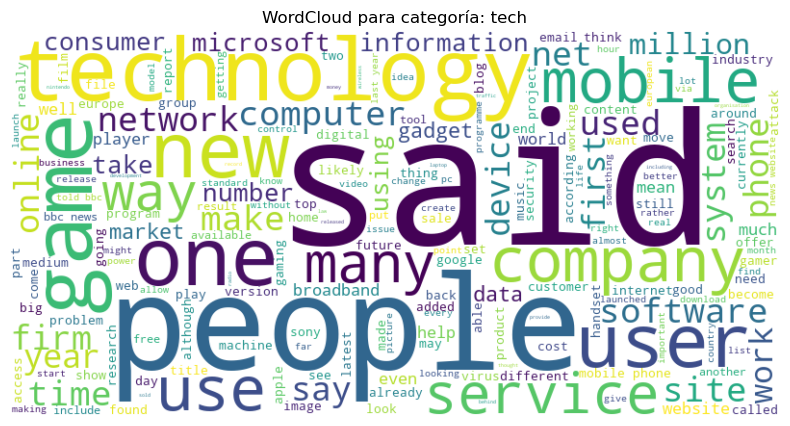

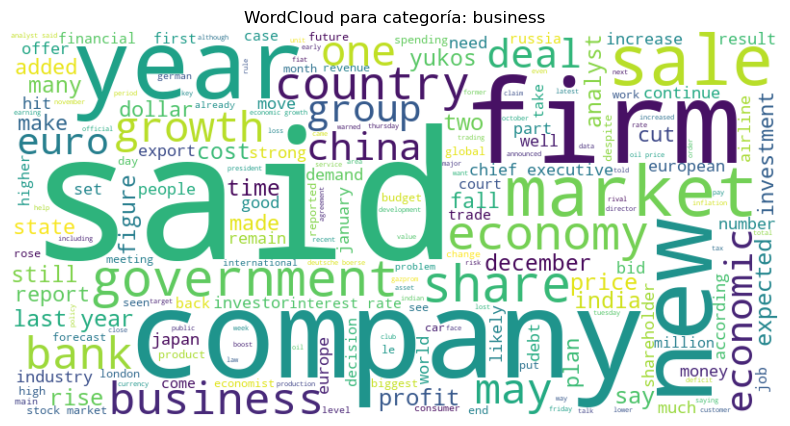

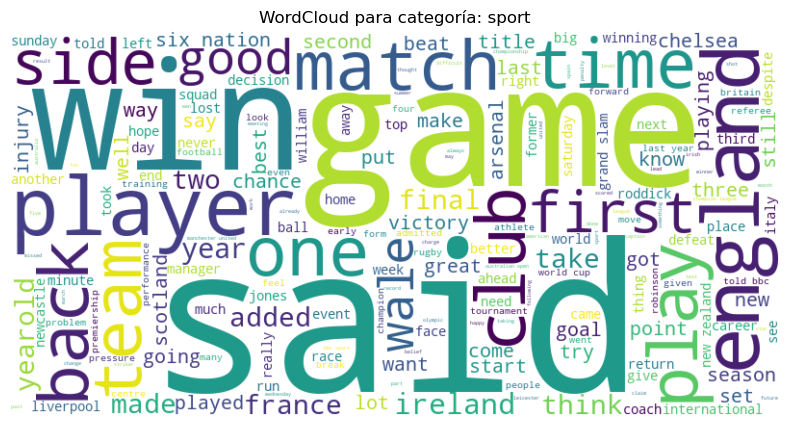

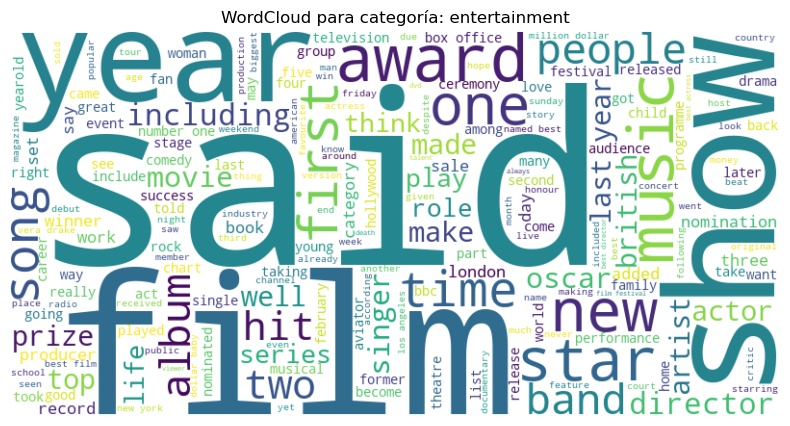

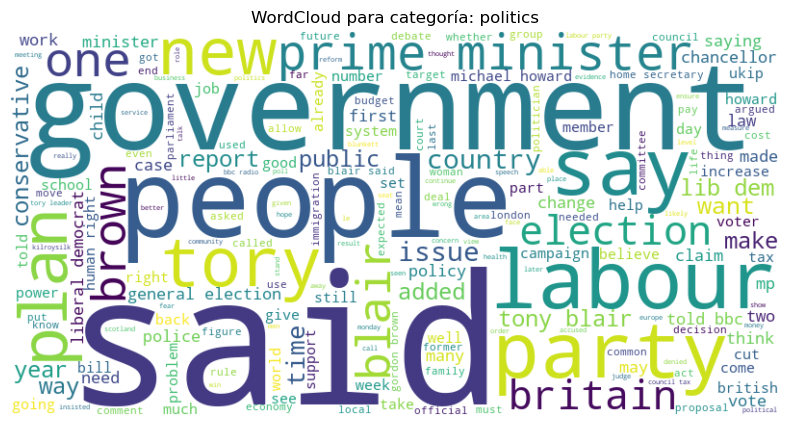

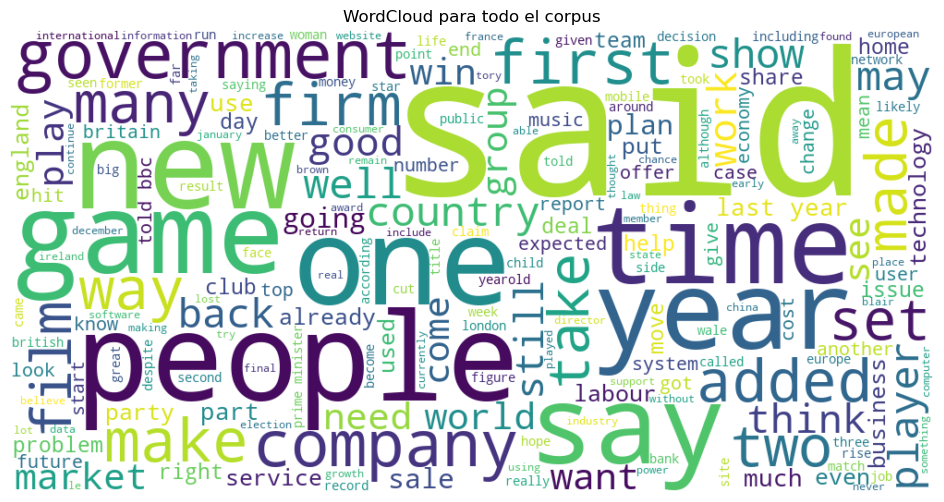

In [16]:
# --------------------------------------------
# 5. Visualización de datos: WordClouds, palabras y n-gramas
# --------------------------------------------
def generate_wordcloud(category):
    text = " ".join(df[df['category'] == category]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud para categoría: {category}")
    plt.show()

# Generamos una para cada categoría:
for cat in df['category'].unique():
    generate_wordcloud(cat)

# Generamos una general para todo el corpus:
all_text = " ".join(df['clean_text'])
wordcloud_all = WordCloud(width=1000, height=500, background_color='white').generate(all_text)
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud para todo el corpus")
plt.show()


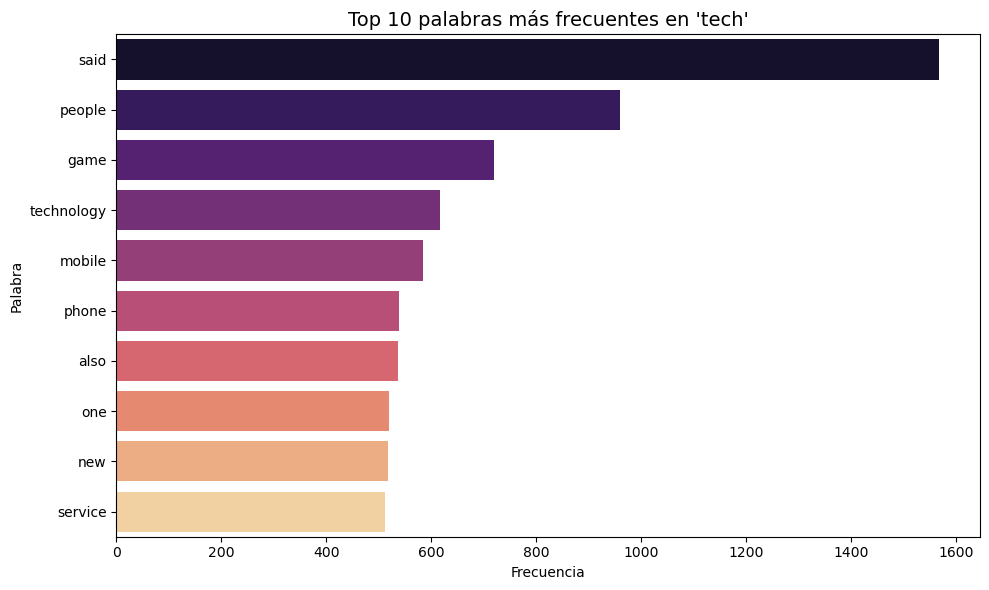

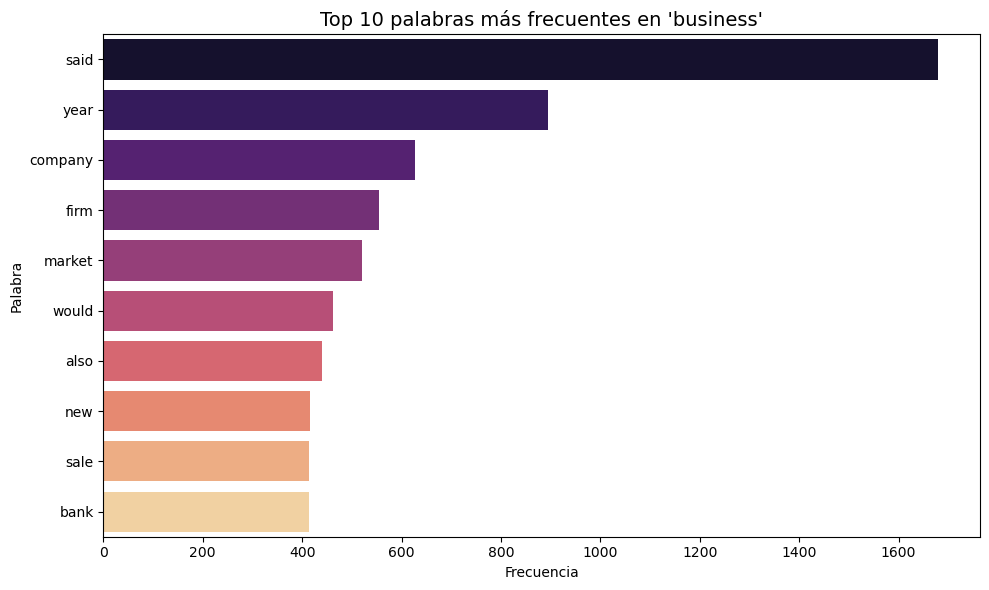

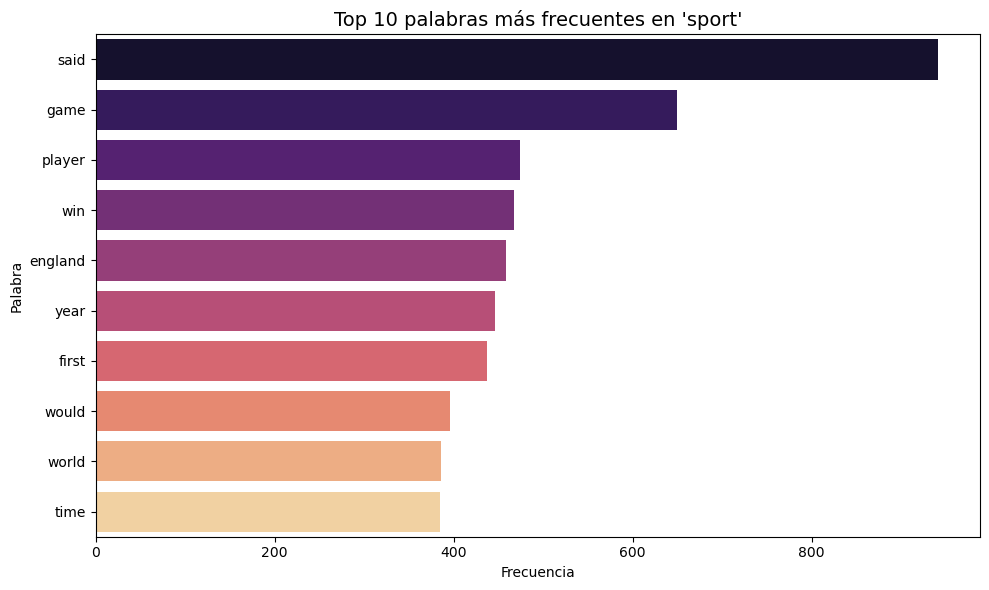

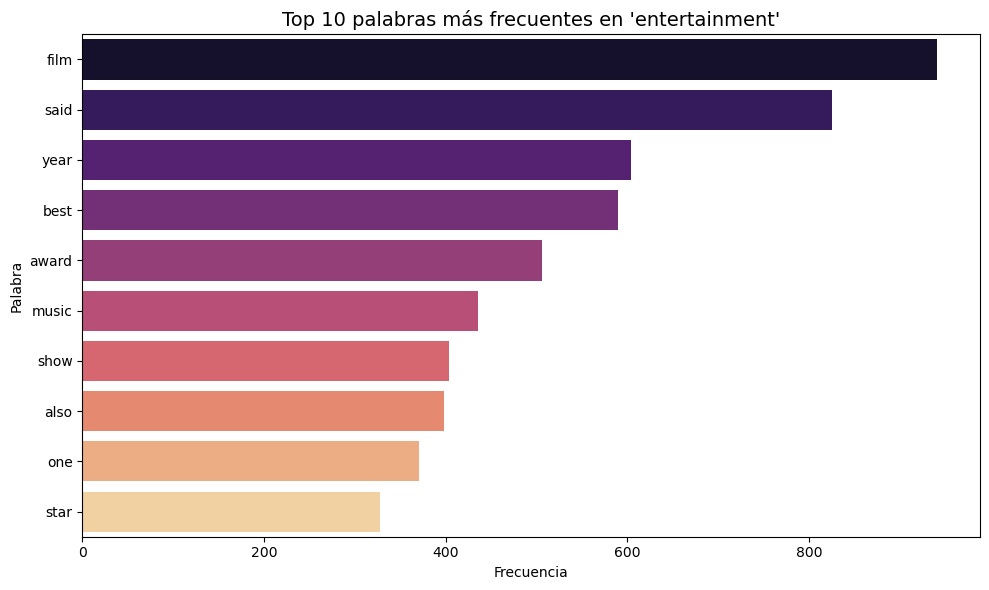

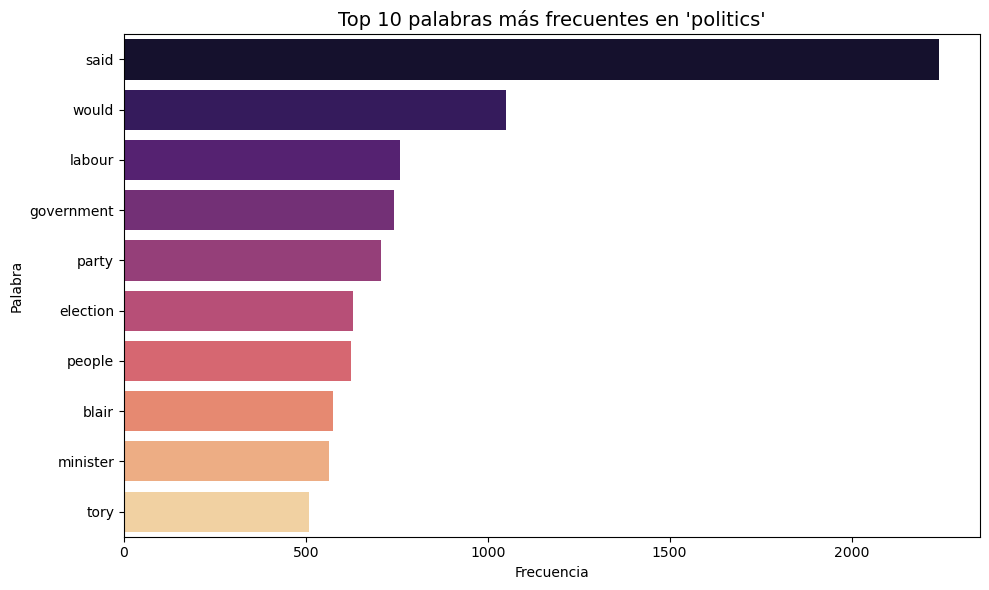

In [17]:
# --------------------------------------------
# 5.1 Gráfico de barras con las 10 palabras más frecuentes por categoría
# --------------------------------------------
from collections import Counter

def plot_top_words(category, top_n=10):
    words = " ".join(df[df['category'] == category]['clean_text']).split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(top_n)
    words, counts = zip(*common_words)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(counts), y=list(words), palette='magma')
    plt.title(f"Top {top_n} palabras más frecuentes en '{category}'", fontsize=14)
    plt.xlabel("Frecuencia")
    plt.ylabel("Palabra")
    plt.tight_layout()
    plt.show()

for cat in df['category'].unique():
    plot_top_words(cat)

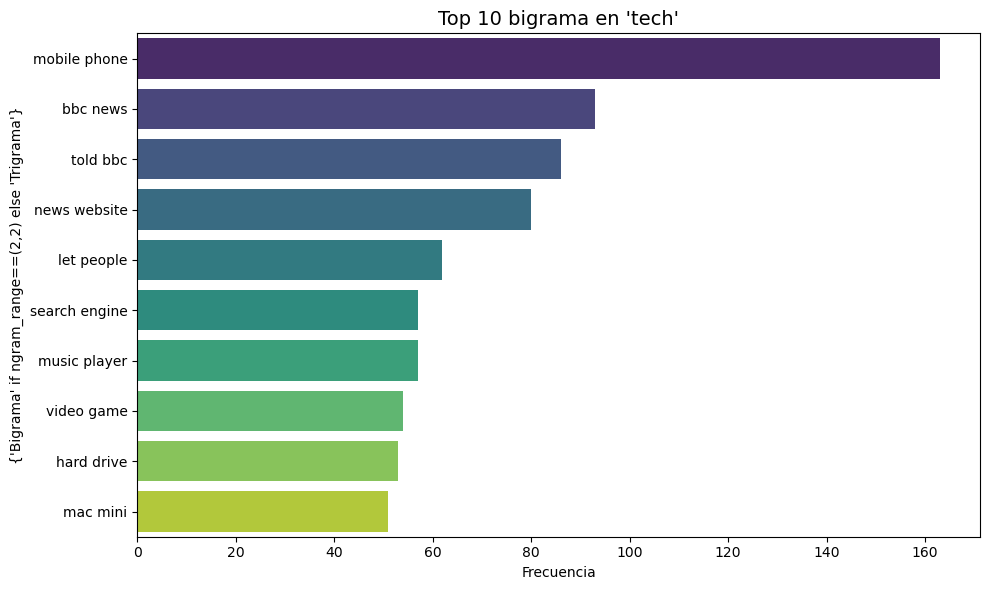

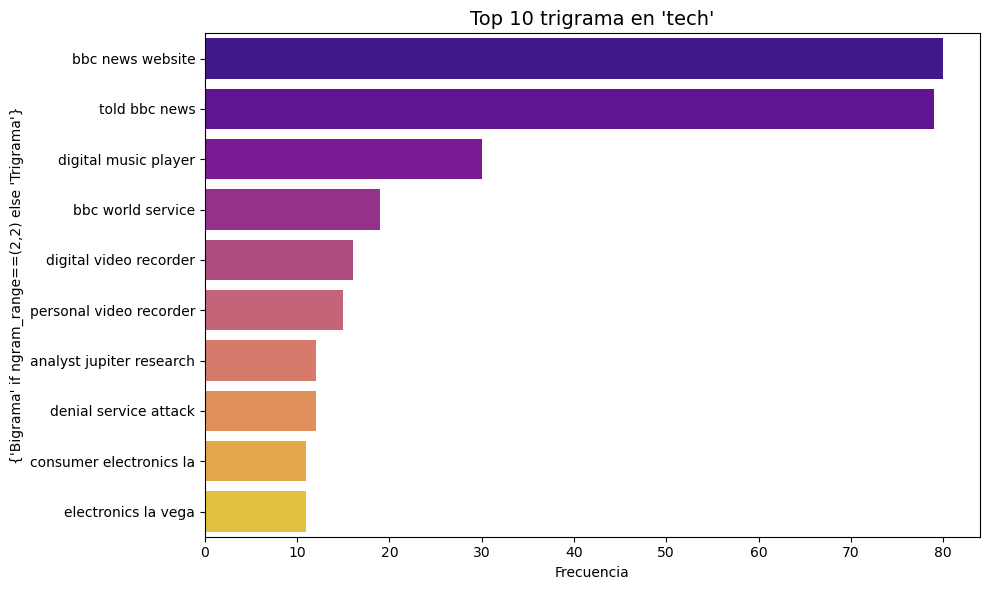

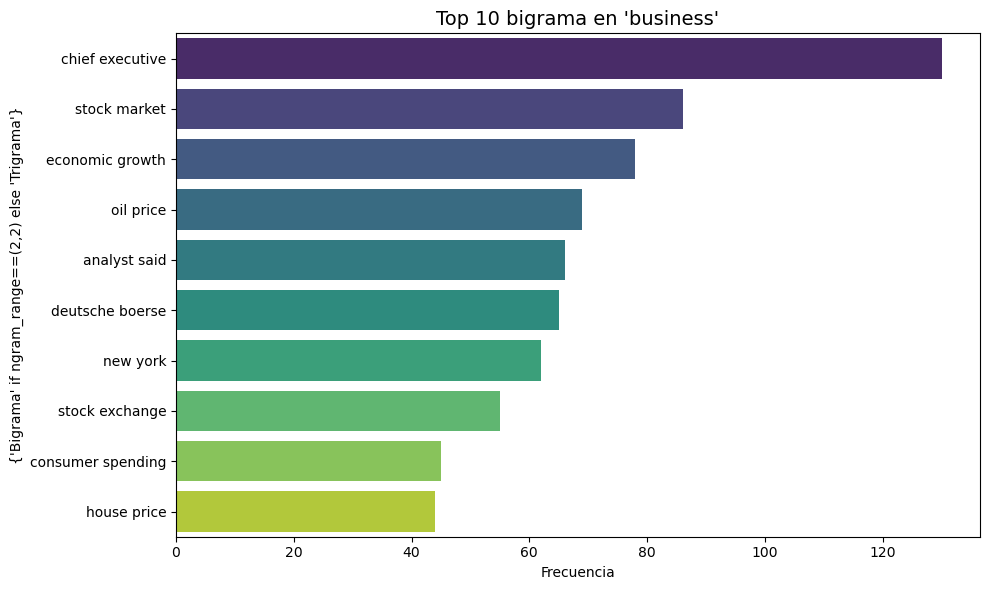

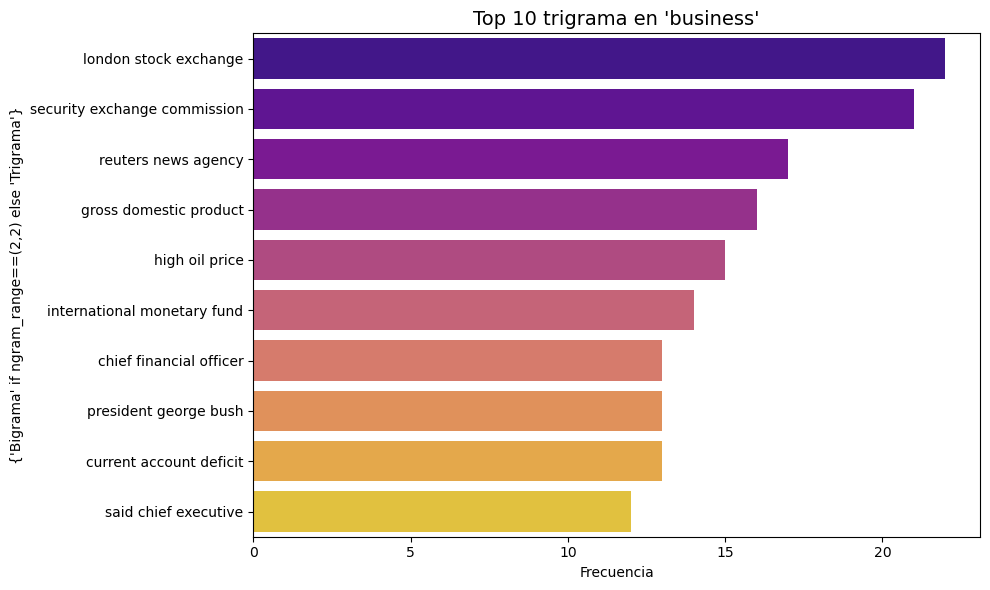

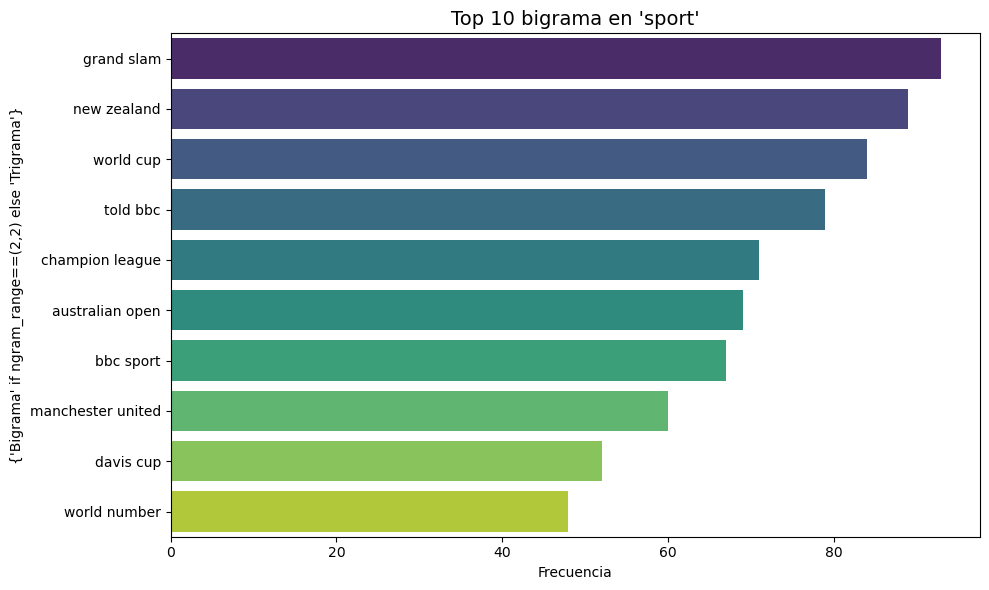

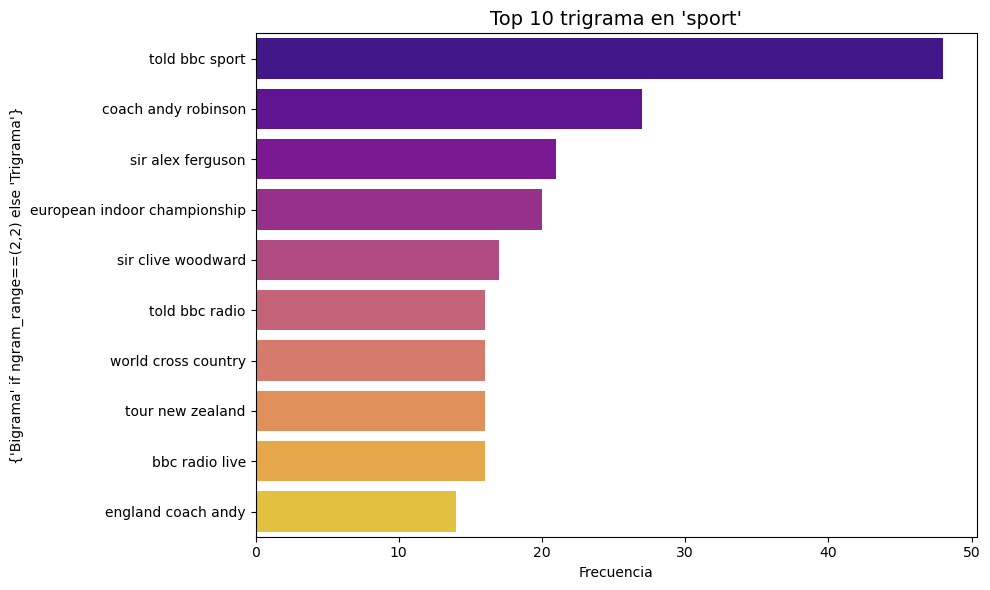

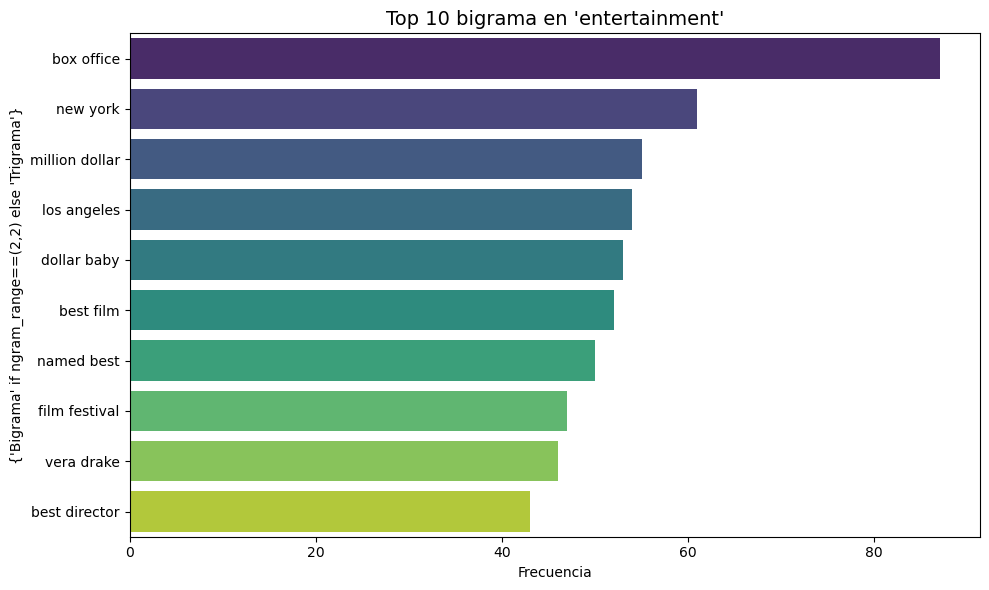

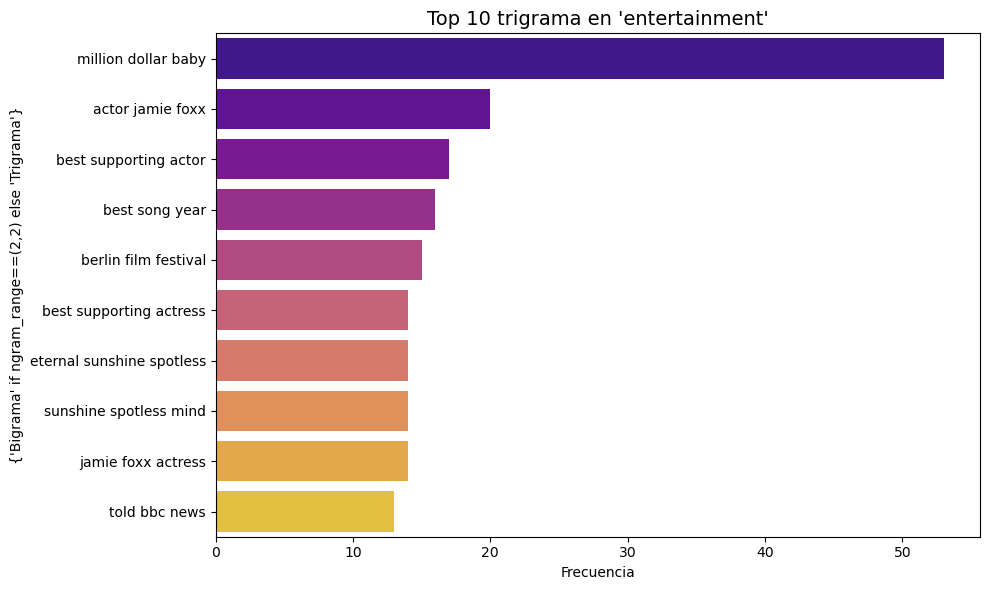

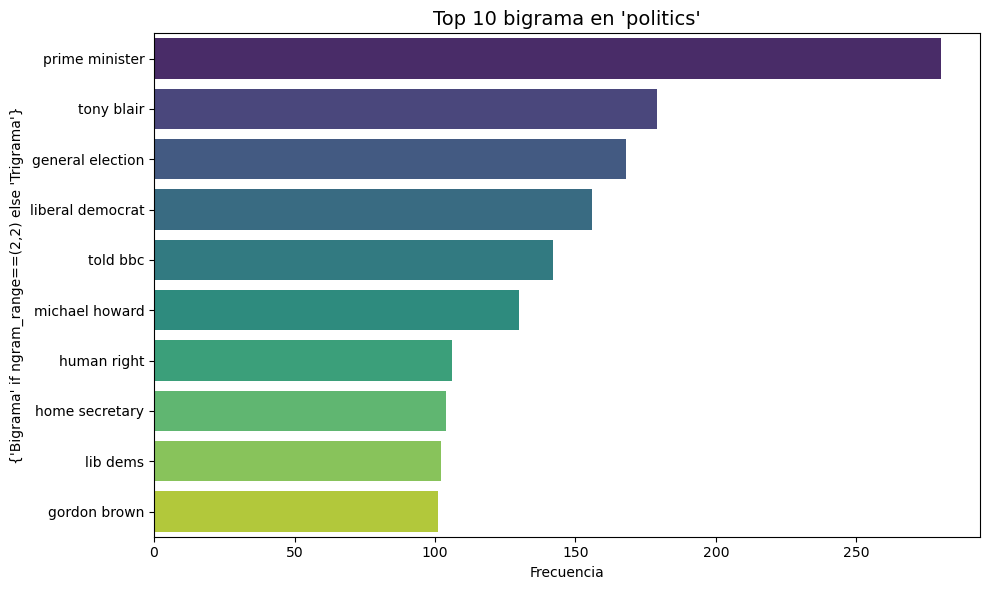

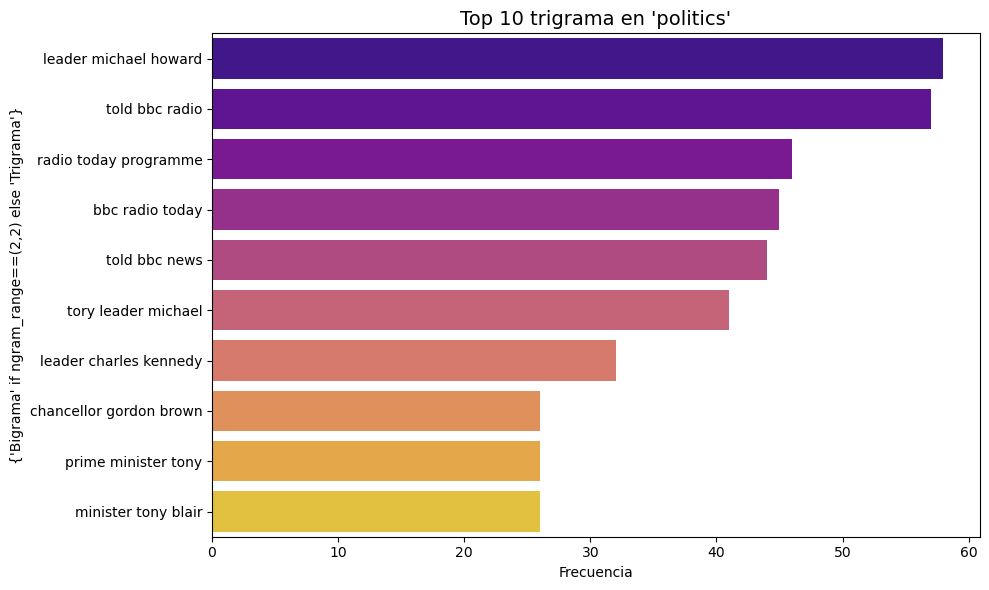

In [18]:
# --------------------------------------------
# 5.2 Bigrama y Trigrama más frecuentes por categoría
# --------------------------------------------


def plot_top_ngrams(category, ngram_range=(2,2), top_n=10):
    subset = df[df['category'] == category]['clean_text']
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    X = vectorizer.fit_transform(subset)
    sum_words = X.sum(axis=0)
    word_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    word_freq = sorted(word_freq, key=lambda x: x[1], reverse=True)[:top_n]
    ngrams, counts = zip(*word_freq)

    plt.figure(figsize=(10, 6))
    palette = 'viridis' if ngram_range == (2, 2) else 'plasma'
    sns.barplot(x=list(counts), y=list(ngrams), palette=palette)
    plt.title(f"Top {top_n} {'bigrama' if ngram_range==(2,2) else 'trigrama'} en '{category}'", fontsize=14)
    plt.xlabel("Frecuencia")
    plt.ylabel("{'Bigrama' if ngram_range==(2,2) else 'Trigrama'}")
    plt.tight_layout()
    plt.show()

for cat in df['category'].unique():
    plot_top_ngrams(cat, ngram_range=(2, 2))  # bigramas
    plot_top_ngrams(cat, ngram_range=(3, 3))  # trigramas

### Parte 2: Modelado

- Transformación del texto utilizando TF-IDF y Bag of Words / Un análisis comparativo entre TF-IDF y BOW

- División del dataset en conjuntos de entrenamiento y prueba.

- Entrenamiento y evaluación con cinco modelos: Regresión Logística, Naive Bayes, Random Forest, SVM y Red Neuronal (MLP).

- Evaluación del rendimiento utilizando métricas como precisión, recall y F1-score / tabla comparativa de precisión y gráfico de barras.

In [20]:
# --------------------------------------------
# 6. Representación vectorial (TF-IDF y BOW)
# --------------------------------------------

bow_vectorizer = CountVectorizer(max_features=5000)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X_bow = bow_vectorizer.fit_transform(df['clean_text'])
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_text'])
y = df['category']

In [21]:
# Visualización de las matrices BOW y TF-IDF (una muestra)
bow_df = pd.DataFrame(X_bow.toarray(), columns=bow_vectorizer.get_feature_names_out())
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

print("\nMatriz BOW - muestra:")
print(bow_df.head())

print("\nMatriz TF-IDF - muestra:")
print(tfidf_df.head())


Matriz BOW - muestra:
   aaa  abandoned  abbott  abc  ability  able  abn  abortion  abroad  absence  \
0    0          0       0    0        0     0    0         0       0        0   
1    0          0       0    0        1     0    0         0       0        0   
2    0          0       0    0        0     0    0         0       0        0   
3    0          0       0    0        0     0    0         0       0        0   
4    0          0       0    0        0     0    0         0       0        0   

   ...  yuan  yugansk  yuganskneftegas  yukos  yushchenko  zealand  zero  \
0  ...     0        0                0      0           0        0     0   
1  ...     0        0                0      0           0        0     0   
2  ...     0        0                0      0           0        0     0   
3  ...     0        0                0      0           0        0     0   
4  ...     0        0                0      0           0        0     0   

   zombie  zone  zurich  
0      

#### Análisis del código para, Representación vectorial (TF-IDF y BOW):


##### 🔹 ¿Qué es bow_df.head()?:

- Crea una matriz de documentos vs palabras (solo las más frecuentes, hasta 5000).

- Cada fila representa un documento (noticia).

- Cada columna es una palabra (token).

- Cada celda indica la cantidad de veces que esa palabra aparece en ese documento.

Esta es una representación de frecuencia absoluta.

##### 📌 Interpretación: 
Si se observa un valor alto para una palabra específica en una fila, significa que esa palabra es muy frecuente en ese documento. Sin embargo, no considera si esa palabra también es común en otros documentos (por eso usamos TF-IDF).


##### 🔹 ¿Qué es tfidf_df.head()?:

- Muestra una matriz similar, pero con valores normalizados por importancia.

- Cada celda contiene un valor entre 0 y 1 que mide la importancia de una palabra en un documento, penalizando aquellas que aparecen en muchos documentos.

##### 📌 Interpretación: 
Un valor alto en TF-IDF indica que esa palabra es característica o distintiva de ese documento, es decir, aparece mucho en ese documento pero poco en otros.



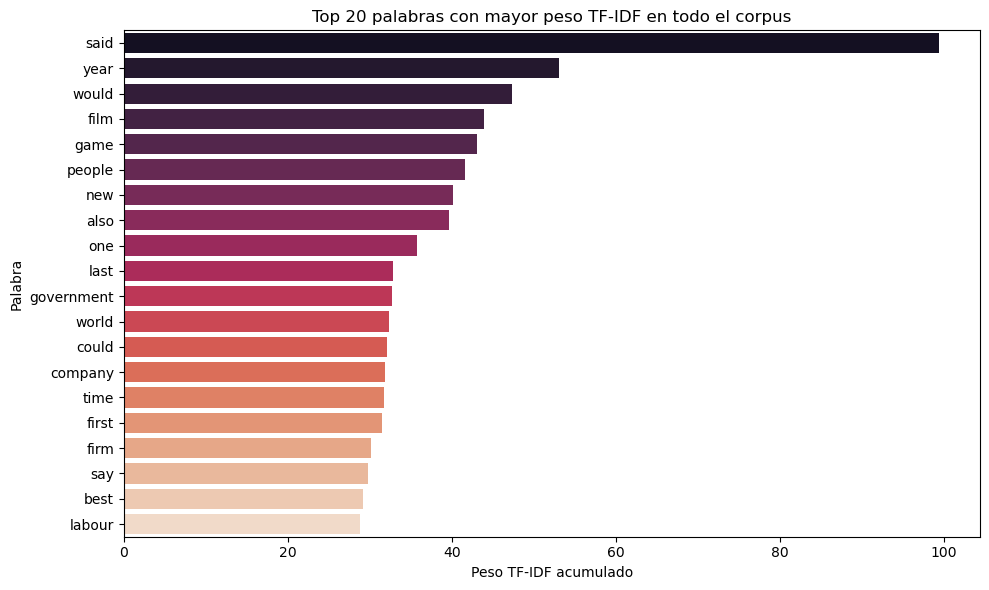

In [23]:
# Palabras más importantes según TF-IDF
tfidf_sum = np.asarray(X_tfidf.sum(axis=0)).ravel()
words = tfidf_vectorizer.get_feature_names_out()

# Crear DataFrame con términos más relevantes
top_tfidf = pd.DataFrame({'word': words, 'tfidf': tfidf_sum})
top_tfidf = top_tfidf.sort_values(by='tfidf', ascending=False).head(20)

# Visualización de top palabras
plt.figure(figsize=(10, 6))
sns.barplot(x='tfidf', y='word', data=top_tfidf, palette='rocket')
plt.title('Top 20 palabras con mayor peso TF-IDF en todo el corpus')
plt.xlabel('Peso TF-IDF acumulado')
plt.ylabel('Palabra')
plt.tight_layout()
plt.show()


#### Explicación del coódigo anterior, sobre Palabras más importantes según TF-IDF:

##### 🔹 Visualización de las palabras con mayor peso TF-IDF:

- Calcula la suma total de los pesos TF-IDF de cada palabra en todo el corpus.

- Se muestran las 20 palabras más influyentes en todo el conjunto de textos.

##### 📌 Interpretación del gráfico:

- Las palabras con mayor peso TF-IDF son probablemente términos clave que distinguen las categorías del corpus (por ejemplo: "Said", "year", "would").

- Estas palabras ayudan más a los modelos de clasificación porque aportan mayor capacidad discriminativa entre clases.

In [51]:
# ------------------------------------------------------------
# 7. División de datos y entrenamiento con múltiples modelos
# ------------------------------------------------------------

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', random_state=42),
    'MLP (Neural Net)': MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"\nModelo: {name}")
    print(classification_report(y_test, y_pred))
    results.append({'Modelo': name, 'Precisión': acc, 'Precisión Ponderada': prec, 'Recall': rec, 'F1-Score': f1})


Modelo: Logistic Regression
               precision    recall  f1-score   support

     business       0.95      0.94      0.95       101
entertainment       1.00      0.94      0.97        81
     politics       0.92      0.98      0.95        83
        sport       0.97      1.00      0.98        98
         tech       0.99      0.96      0.98        82

     accuracy                           0.96       445
    macro avg       0.97      0.96      0.96       445
 weighted avg       0.96      0.96      0.96       445


Modelo: Naive Bayes
               precision    recall  f1-score   support

     business       0.95      0.95      0.95       101
entertainment       1.00      0.91      0.95        81
     politics       0.92      0.98      0.95        83
        sport       0.99      1.00      0.99        98
         tech       0.96      0.98      0.97        82

     accuracy                           0.96       445
    macro avg       0.96      0.96      0.96       445
 weighted 

#### 🔍 Análisis individual por modelo, División de datos y entrenamiento:

##### 1. MLPClassifier (Red Neuronal Multicapa):
- Mejor desempeño general (F1 = 0.966).

- Detecta relaciones no lineales en los datos de texto gracias a sus capas ocultas.

- Ventaja: Puede capturar patrones complejos que otros modelos lineales no pueden.

- Ideal para grandes volúmenes de texto si se escala correctamente.

##### 2. Logistic Regression:
- Modelo lineal muy eficiente.

- Rendimiento sobresaliente considerando su simplicidad (F1 = 0.964).

- Beneficiado por la representación TF-IDF, que convierte texto en un espacio vectorial linealmente separable.

- Rápido y útil para producción.

##### 3. Naive Bayes:
- Aunque muy rápido y eficiente para texto, parte de la suposición de independencia entre palabras, lo que limita su capacidad para capturar relaciones semánticas.

- Sin embargo, logró un F1 alto (0.964), mostrando que el preprocesamiento fue eficaz para eliminar ruido.

##### 4. SVM (Support Vector Machine):
- F1 = 0.964. Excelente capacidad de generalización.

- Al usar kernel lineal con TF-IDF, encuentra un buen hiperplano de separación entre clases.

- Recomendado para problemas con texto bien diferenciado.

##### 5. Random Forest:
- Peor desempeño relativo (F1 = 0.944).

- Tiende a sobreajustar datos con alta dimensionalidad como texto vectorizado.

- No captura relaciones semánticas bien con matrices dispersas como TF-IDF sin reducción de dimensionalidad.

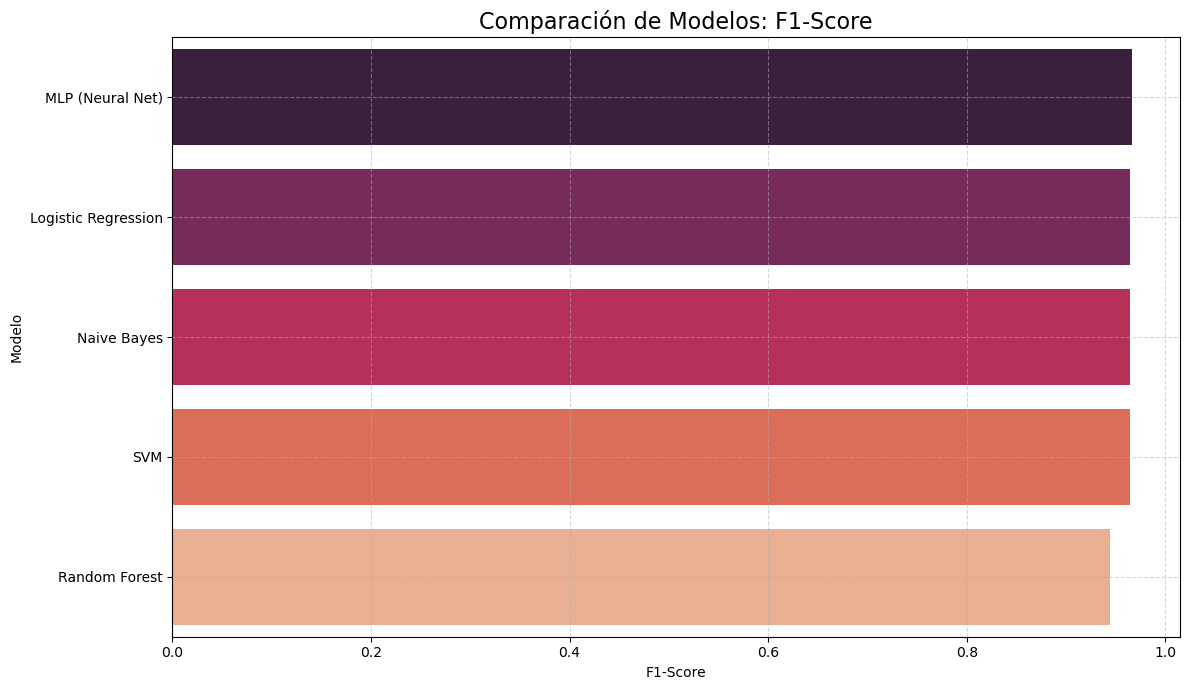

,Modelo,Precisión,Precisión Ponderada,Recall,F1-Score
4,MLP (Neural Net),0.966292,0.966704,0.966292,0.966300
0,Logistic Regression,0.964045,0.964970,0.964045,0.964096
1,Naive Bayes,0.964045,0.965043,0.964045,0.964025
3,SVM,0.964045,0.964261,0.964045,0.963954
2,Random Forest,0.943820,0.944851,0.943820,0.943802


In [69]:
# --------------------------------------------
# 8. Evaluación comparativa
# --------------------------------------------
results_df = pd.DataFrame(results).sort_values(by='F1-Score', ascending=False)

fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(data=results_df, y='Modelo', x='F1-Score', palette='rocket', ax=ax)
plt.title('Comparación de Modelos: F1-Score', fontsize=16)
plt.xlabel('F1-Score')
plt.ylabel('Modelo')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Tabla comparativa de métricas, ordenada con el mejor F1-Score:
styled_table = results_df.style.background_gradient(cmap='Oranges').set_caption("Comparativa Final de Modelos (Mejor ordenado por F1-Score)")
display(styled_table)

#### 📊 Comparativa Final de Modelos:

##### 📌 ¿Por qué se eligió F1-Score como métrica principal?
El F1-Score ponderado, combina precisión y recall, penalizando tanto los falsos positivos como los falsos negativos. Esto es crucial en clasificación multiclase, donde un modelo podría tener alta precisión en una clase dominante pero fallar en otras. Usar solo precisión o recall puede ocultar ese sesgo, mientras que el F1 ponderado lo revela.

##### 💡 Conclusiones para la comparativa final de modelos:
- ✅ MLPClassifier es el modelo ganador, por su F1-Score más alto, gracias a su capacidad de modelar relaciones complejas no lineales.

- 🔠 La elección de TF-IDF fue clave, ya que mejoró el rendimiento global respecto a BOW.

- 📈 Modelos lineales como SVM y Logistic Regression también ofrecieron resultados muy competitivos, lo que sugiere que el problema es linealmente separable.

- ⚠️ Naive Bayes, a pesar de su simplicidad, fue sorprendentemente competitivo, lo que valida la calidad del preprocesamiento.

### 8. 🧠 Conclusión Final del Proyecto:

##### 🎯 Resumen de objetivos alcanzados:
El objetivo principal del proyecto fue desarrollar un modelo de clasificación automática de noticias del dataset BBC News, aplicando técnicas de Procesamiento de Lenguaje Natural (NLP) y modelos de aprendizaje supervisado. Se buscaba demostrar que, mediante un pipeline de NLP bien estructurado y una correcta elección del modelo, es posible organizar y clasificar contenido textual con alta precisión, eficiencia y escalabilidad.

##### 📊 Aspectos más importantes del análisis:

###### Preprocesamiento exhaustivo de texto:

- Tokenización, lematización, remoción de stopwords, generación de n-gramas, y análisis de frecuencia permitieron construir una base sólida para el modelado.

- Las visualizaciones como nubes de palabras y barras por categoría brindaron claridad sobre la distribución del contenido por tema.

###### Representación vectorial:

- La combinación de técnicas BOW y TF-IDF permitió transformar eficazmente el texto en variables numéricas interpretables.

- Se observó que TF-IDF mejoró el rendimiento de los modelos, destacando la importancia de términos distintivos en cada categoría.


###### Modelado y evaluación comparativa:

- Se entrenaron y compararon cinco modelos: MLPClassifier, Logistic Regression, Naive Bayes, SVM y Random Forest.

- Se evaluaron utilizando métricas de Precisión, Recall, Precisión Ponderada y F1-Score, siendo esta última la métrica principal por equilibrar precisión y exhaustividad en tareas multiclase.


#### 🏆 Modelo ganador y análisis:

| Modelo               | Precisión | Precisión Ponderada | Recall    | F1-Score  |
| -------------------- | --------- | ------------------- | --------- | --------- |
| 🥇 **MLPClassifier** | **0.966** | **0.967**           | **0.966** | **0.966** |
| Logistic Regression  | 0.964     | 0.965               | 0.964     | 0.964     |
| Naive Bayes          | 0.964     | 0.965               | 0.964     | 0.964     |
| SVM                  | 0.964     | 0.964               | 0.964     | 0.964     |
| Random Forest        | 0.944     | 0.945               | 0.944     | 0.944     |

###### - MLPClassifier (Red Neuronal) fue el mejor modelo global según el F1-Score, gracias a su capacidad de capturar relaciones no lineales complejas. Su rendimiento constante en todas las métricas lo convierte en un candidato robusto para implementación.

###### - Logistic Regression y SVM también ofrecieron excelentes resultados, lo que valida la calidad del preprocesamiento y la representación TF-IDF.

###### - Naive Bayes logró destacar a pesar de su simplicidad, beneficiándose del carácter bien estructurado del corpus.

###### - Random Forest, aunque útil en muchos casos, tuvo menor rendimiento posiblemente debido a la naturaleza dispersa y alta dimensionalidad de los vectores TF-IDF.


#### 🔍 Insights claves del proyecto:

- La limpieza del texto y la correcta vectorización fueron factores críticos para el rendimiento de los modelos.

- Las categorías del dataset están bien definidas y presentan un bajo solapamiento semántico, lo que facilitó la clasificación.

- TF-IDF fue superior a BOW en términos de discriminación entre clases.


#### 🚀 Aplicación del modelo ganador a la operatividad empresarial:

###### Implementar el modelo MLPClassifier permitiría:

- Automatizar la categorización de noticias en redacciones digitales.

- Optimizar flujos de trabajo de curaduría y organización de contenido.

- Mejorar sistemas de recomendación de artículos según temas de interés.



### 9. 🔮 Perspectivas a futuro y Mejoras sugeridas al proyecto:

##### Qué se puede mejorar:
- Incluir embeddings contextuales avanzados como Word2Vec, FastText o BERT para capturar relaciones semánticas más profundas.

- Aplicar técnicas de optimización de hiperparámetros (e.g., GridSearchCV).

- Explorar enfoques de ensembles, como VotingClassifier o Stacking.

##### Cuales serian las Perspectivas futuras:
- Desplegar MLPClassifier en entornos de producción.

- Ampliar a textos en múltiples idiomas.

- Adaptar a clasificación multi-etiqueta.




